# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a private s3 bucket:s3://sta9760-yelpdata-qq/yelp_academic_dataset_business.json

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install pandas and matplotlib.

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.1.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1606179854974_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
cycler                     0.10.0   
jmespath                   0.10.0   
joblib                     0.16.0   
kiwisolver                 1.3.1    
lxml                       4.5.2    
matplotlib                 3.1.0    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     1.0.3    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  2.4.7    
python-dateutil            2.8.1    
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
setuptools                 28.8.0   
six                        1.13.0   
soupsieve                  1.9.5    
t

# Importing

Now, import the installed packages from the previous block below.

In [10]:
from pyspark.sql import SparkSession

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loading Data

We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [7]:
spark = SparkSession \
        .builder \
        .appName("Analysis") \
        .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
df=spark.read.json("s3://sta9760-yelpdata-qq/yelp_academic_dataset_business.json")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Overview of Data

Display the number of rows and columns in our dataset.

In [14]:
print(f'Total Columns: {len(df.dtypes)}')
print(f'Total Rows: {df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393

In [15]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

- business_id
- name
- city
- state
- categories

In [16]:
df = df.select('business_id','name','city','state','stars','categories')
df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+-----+--------------------+
|         business_id|                name|           city|state|stars|          categories|
+--------------------+--------------------+---------------+-----+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|  3.5|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|  5.0|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|  5.0|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|  2.5|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|  4.5|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: how many unique categories are represented in this dataset?

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

- How many businesses are categorized as Active Life, for instance
- What are the top 20 most popular categories available?

# Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [18]:
from pyspark.sql.functions import split, explode, concat, concat_ws

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
df1=df.select('business_id','categories')\
.withColumn('category',explode(split(df['categories'], ", ")))\
.drop('categories')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
df1.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

# Total Unique Categories

Finally, we are ready to answer the question: what is the total number of unique categories available?

Below, implement the code necessary to calculate this figure.

In [53]:
df1.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

# Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

# Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

In [56]:
df2=df1.groupBy('category').count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
df2.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Dermatologists|  341|
|      Paddleboarding|   36|
|        Aerial Tours|   28|
|         Hobby Shops|  828|
|          Bubble Tea|  720|
|             Embassy|   13|
|            Handyman|  682|
|             Tanning|  938|
|      Aerial Fitness|   29|
|             Tempura|    1|
|             Falafel|  159|
|       Outlet Stores|  399|
|        Summer Camps|  318|
|     Clothing Rental|   55|
|      Sporting Goods| 2311|
|     Cooking Schools|  118|
|  College Counseling|   15|
|  Lactation Services|   50|
|Ski & Snowboard S...|   50|
|             Museums|  359|
+--------------------+-----+
only showing top 20 rows

# Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories.

HINT: don't forget about the matplotlib magic!

%matplot plt

In [58]:
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
df3 = df2.orderBy('count',ascending=False)
df3.show(20)
pd_df = df3.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+
only showing top 20 rows

In [60]:
df_temp =pd_df.head(20).copy().sort_values(by='count')
plt.barh(y= df_temp["category"], width = df_temp["count"], color="skyblue", height= 0.8)
plt.title("Top Categories By Business")
plt.box(False)
plt.xlabel("count")
plt.ylabel("category")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0, 0.5, 'category')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

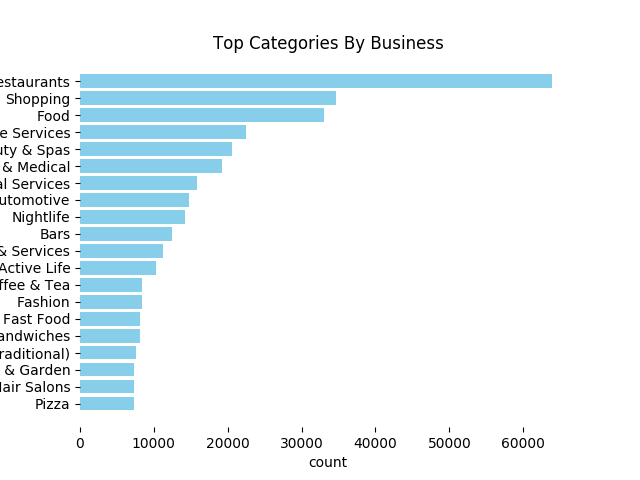

In [61]:
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

How true is this really? Let's try and answer this question.

# Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [62]:
df_user=spark.read.json("s3://sta9760-yelpdata-qq/yelp_academic_dataset_review.json")
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

In [63]:
df_user_select = df_user.select('business_id','stars')
df_user_select.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the stars column to get a resultant dataframe that displays average stars per business as accumulated by users who took the time to submit a written review.

In [64]:
df_user_avg=df_user_select.groupBy('business_id').avg('stars')
df_user_avg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|kpbhERZoj1eTDRnMV...| 2.033333333333333|
|ipFreSFhjClfNETuM...|               2.6|
|9A_mB7Ez3RIh26EN5...|               2.6|
+--------------------+------------------+
only showing top 5 rows

In [65]:
df_user_join = df_user_avg.join(df, 'business_id', 'inner').select('avg(stars)','stars','name','city','state')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [66]:
df_user_join.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-----+--------------------+---------+-----+
|      avg(stars)|stars|                name|     city|state|
+----------------+-----+--------------------+---------+-----+
|4.11784140969163|  4.0|Delmonico Steakhouse|Las Vegas|   NV|
|             4.5|  4.5|Mr. Pancho Mexica...|     Mesa|   AZ|
|            3.75|  4.0|Maricopa County D...|  Phoenix|   AZ|
|             4.0|  4.0|Double Play Sport...|Las Vegas|   NV|
|          2.6875|  2.5|  Impressions Dental| Chandler|   AZ|
+----------------+-----+--------------------+---------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the skew (for lack of a better word) between the avg stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote an actual review and reviewers who just provided a star rating).

The formula you can use is something like:

    (row['avg(stars)'] - row['stars']) / row['stars']
    
If the skew is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If skew is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [67]:
df2=df_user_join.withColumn('skew',(df_user_join['avg(stars)'] - df_user_join['stars']) / df_user_join['stars'])
df2.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-----+--------------------+---------+-----+--------------------+
|      avg(stars)|stars|                name|     city|state|                skew|
+----------------+-----+--------------------+---------+-----+--------------------+
|4.11784140969163|  4.0|Delmonico Steakhouse|Las Vegas|   NV|0.029460352422907565|
|             4.5|  4.5|Mr. Pancho Mexica...|     Mesa|   AZ|                 0.0|
|            3.75|  4.0|Maricopa County D...|  Phoenix|   AZ|             -0.0625|
|             4.0|  4.0|Double Play Sport...|Las Vegas|   NV|                 0.0|
|          2.6875|  2.5|  Impressions Dental| Chandler|   AZ|               0.075|
+----------------+-----+--------------------+---------+-----+--------------------+
only showing top 5 rows

In [68]:
sc.install_pypi_package("seaborn==0.9.0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

In [69]:
import pandas as pd  
import numpy as np
import seaborn as sns
df_pd2=df2.select('skew').toPandas()
plt.figure(figsize=(9,6))
sns.distplot(df_pd2)
plt.box(False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

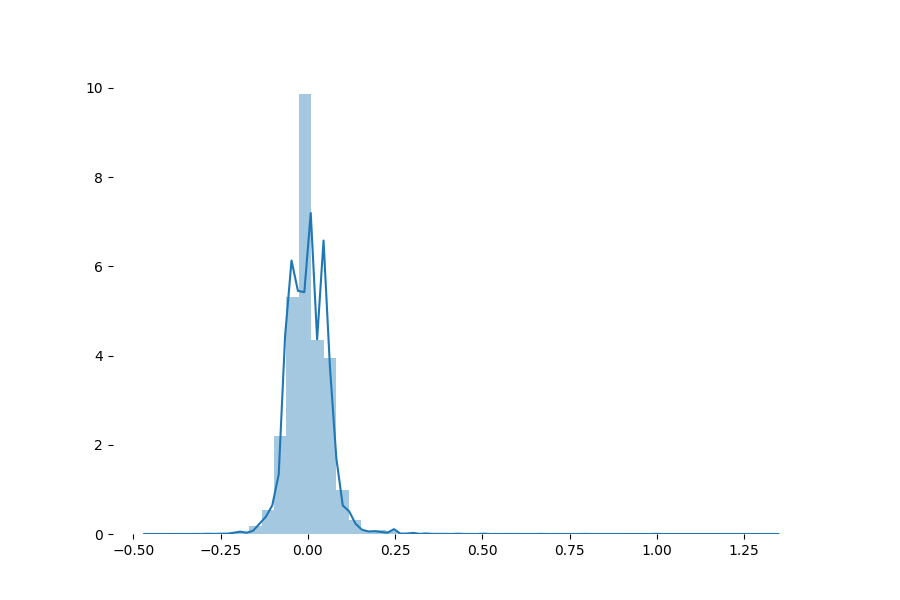

In [70]:
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

- Try and analyze some interesting dimension to this data. The ONLY requirement is that you must use the Users dataset and join on either the business* or reviews** dataset
- Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

In [71]:
user_dataset=spark.read.json("s3://sta9760-yelpdata-qq/yelp_academic_dataset_user.json")
user_dataset.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [72]:
df_avg =df_user.select('user_id','stars').groupBy('user_id').avg('stars')
df_avg.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|             user_id|        avg(stars)|
+--------------------+------------------+
|1Dul59QEe-Q-7OQHT...|              3.75|
|z2Gi5vo-8j544qN_g...|               4.5|
|CzkWUMIYDxUSetfCR...| 4.235294117647059|
|Uf_TVv1Z4s024jdI4...|               4.0|
|QSWr7Oivp0mClj_PR...|3.6666666666666665|
|ouvhv-E3S57SQ4ser...|              4.25|
|bD1Ozf99dm2RwpB2N...|             3.875|
|jOy777Ve5jNE6YP-M...|               4.0|
|HJIaRw_DVI8iPuj4F...|3.0392156862745097|
|3pMczoCBOSKBcqMhV...| 4.275862068965517|
+--------------------+------------------+
only showing top 10 rows

In [73]:
df_join= user_dataset.join(df_avg,'user_id','inner').select('avg(stars)','average_stars','user_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
df_join.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------------+--------------------+
|       avg(stars)|average_stars|             user_id|
+-----------------+-------------+--------------------+
|              5.0|          5.0|---RfKzBwQ8t3wu-L...|
|              3.0|         2.75|--1UpCuUDJQbqiuFX...|
|              5.0|          5.0|--AGAPpP1pgp1afbq...|
|              4.0|          4.0|--C-42rr7hPSsUROJ...|
|              3.4|         3.78|--ChzqcPs4YFWlw1j...|
|              5.0|         4.56|--ET3paBtrThD95dk...|
|              5.0|          5.0|--GLTFzU93A40YB56...|
|              2.0|          3.6|--I4wRDhmM2J2VLzK...|
|4.666666666666667|         4.67|--RquisWmBzcezXZr...|
|              2.0|         4.14|--UizzbnQlZg7bEv2...|
+-----------------+-------------+--------------------+
only showing top 10 rows

In [75]:
df_res = df_join.withColumn('average_stars_skew',(df_join['avg(stars)'] - df_join['average_stars']) / df_join['average_stars'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
df_res.show(15)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------------+--------------------+--------------------+
|       avg(stars)|average_stars|             user_id|  average_stars_skew|
+-----------------+-------------+--------------------+--------------------+
|              5.0|          5.0|---RfKzBwQ8t3wu-L...|                 0.0|
|              3.0|         2.75|--1UpCuUDJQbqiuFX...| 0.09090909090909091|
|              5.0|          5.0|--AGAPpP1pgp1afbq...|                 0.0|
|              4.0|          4.0|--C-42rr7hPSsUROJ...|                 0.0|
|              3.4|         3.78|--ChzqcPs4YFWlw1j...|-0.10052910052910051|
|              5.0|         4.56|--ET3paBtrThD95dk...| 0.09649122807017553|
|              5.0|          5.0|--GLTFzU93A40YB56...|                 0.0|
|              2.0|          3.6|--I4wRDhmM2J2VLzK...| -0.4444444444444445|
|4.666666666666667|         4.67|--RquisWmBzcezXZr...|-7.13775874375367...|
|              2.0|         4.14|--UizzbnQlZg7bEv2...| -0.5169082125603864|
|4.166666666

In [77]:
df_pd_res=df_res.select('average_stars_skew').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

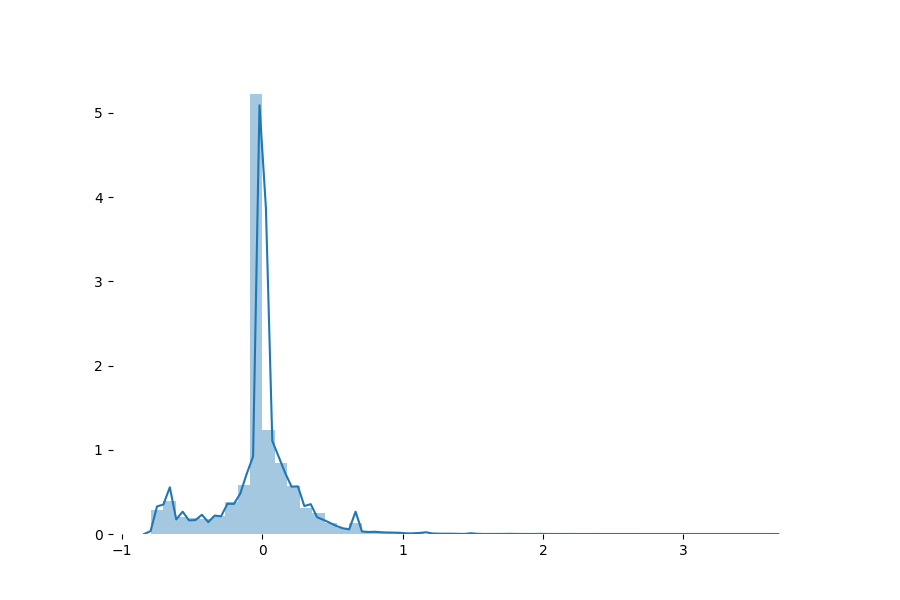

In [78]:
plt.figure(figsize=(9,6))
sns.distplot(df_pd_res)
plt.box(False)
%matplot plt